In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 

In [3]:
df = pd.read_csv("bandit_data.csv")
df.head()



,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse
0,11.0,11.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
1,12.0,12.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
2,13.0,13.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
3,14.0,14.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1
4,15.0,15.0,1.0,0.0,1.0,90-10,1.0,58.0,m1_77,m1


In [5]:

print("Decisions:", df['Decision'].unique()) #1, 0 for chosen vs not chosen
print("Target Arm:", df['Target'].unique()) #1 for high-reward option, 0 for low-reward option
print("Reward Arm:", df['Reward'].unique()) #1 for got reward, 0 for no reward
print("Conditions", df['Condition'].unique()) #prob conditions
print("Switch Arms:", df['Switch'].unique())
print("Block Trial Median:", df['blockTrial'].median()) #trial all in one era (pre-switch)
print("Mean Block Length:", df['blockLength'].mean())
print("Block Length:", df['blockLength'].max()) #blocks are all of different lengths -
print("Block Length:", df['blockLength'].min()) #1.....
print("Max Trials", df['Trial'].max()) #1219 is the max number of trials
print("Min Trials", df['Trial'].min()) #11 at minimum
print("Medin Trials", df['Trial'].median())

Decisions: [1. 0.]
Target Arm: [1. 0.]
Reward Arm: [1. 0.]
Conditions ['90-10' '80-20' '70-30']
Switch Arms: [0. 1.]
Block Trial Median: 33.0
Mean Block Length: 93.75309699194663
Block Length: 447.0
Block Length: 1.0
Max Trials 1219.0
Min Trials 11.0
Medin Trials 372.0


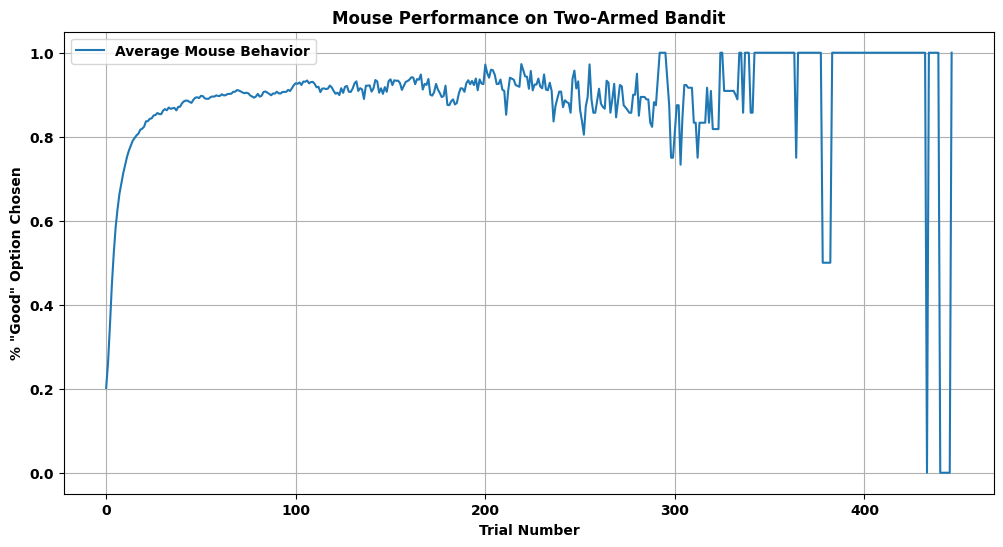

In [7]:
import matplotlib.pyplot as plt
import numpy as np

df['correct_choice'] = (df['Decision'] == df['Target']).astype(int) #check if the Decision == Target (correct choice)


average_mouse_behavior = df.groupby('blockTrial')['correct_choice'].mean()

plt.figure(figsize=(12, 6))
plt.plot(average_mouse_behavior.index, average_mouse_behavior.values, label='Average Mouse Behavior')

plt.title('Mouse Performance on Two-Armed Bandit')
plt.xlabel('Trial Number')
plt.ylabel('% "Good" Option Chosen')
plt.legend()
plt.grid(True)
plt.show()

Variation in the number of trials completed because they are mice -- so in main analysis, can limit the trial number to 382!! 

In [16]:
subset_df = df[df['Trial'] <= 800]


/var/folders/jl/6cpcgscn66v90thk48s_d56r0000gn/T/ipykernel_39093/122996701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['correct_choice'] = (subset_df['Decision'] == subset_df['Target']).astype(int) #check if the Decision == Target (correct choice)


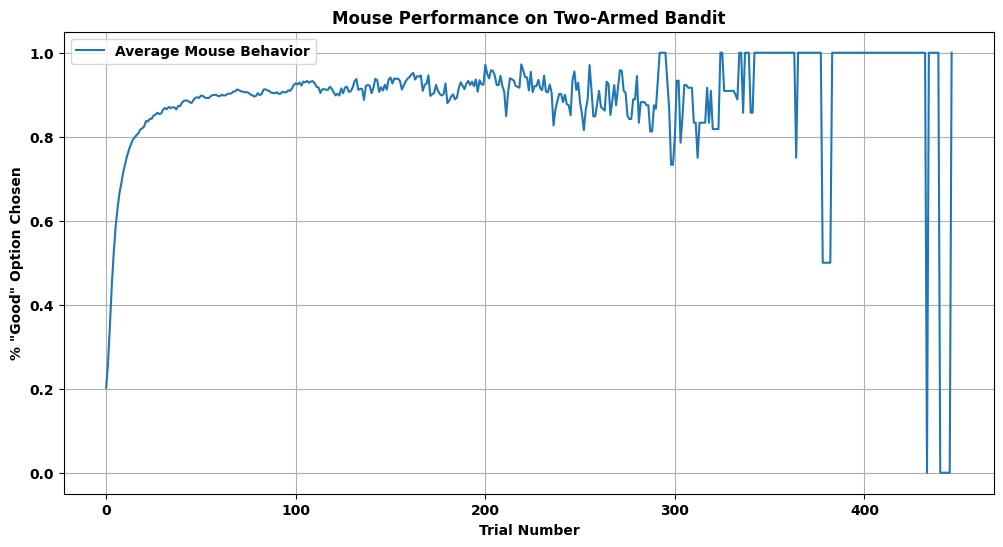

In [ ]:
subset_df['correct_choice'] = (subset_df['Decision'] == subset_df['Target']).astype(int) #check if the Decision == Target (correct choice)


average_mouse_behavior = subset_df.groupby('blockTrial')['correct_choice'].mean()

plt.figure(figsize=(12, 6))
plt.plot(average_mouse_behavior.index, average_mouse_behavior.values, label='Average Mouse Behavior')

plt.title('Mouse Performance on Two-Armed Bandit')
plt.xlabel('Trial Number')
plt.ylabel('% "Good" Option Chosen')
plt.legend()
plt.grid(True)
plt.show()


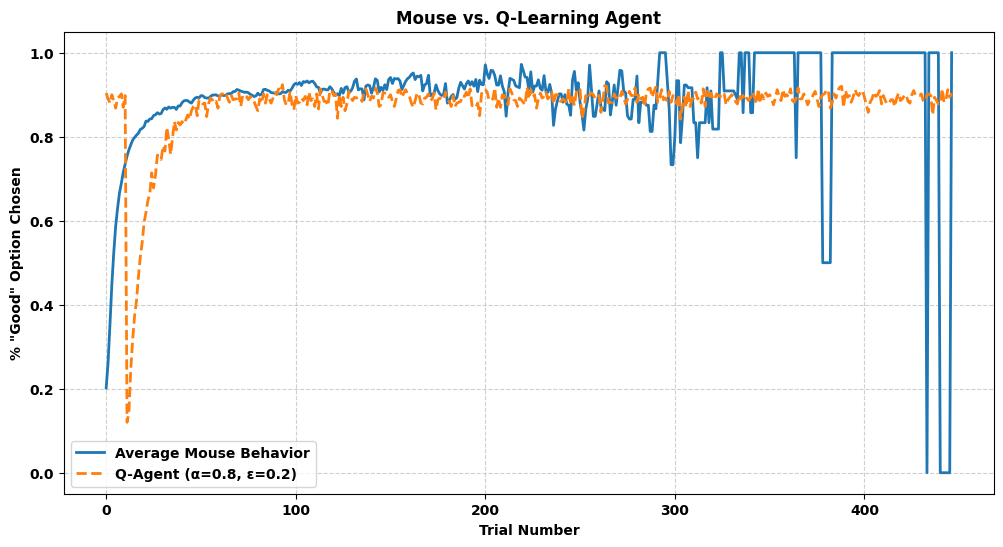

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


data = subset_df

def parse_condition(condition_str):
    """Parses a string like '80-20' into (0.8, 0.2)"""
    parts = condition_str.split('-')
    prob_high = float(parts[0]) / 100.0
    prob_low = float(parts[1]) / 100.0
    return prob_high, prob_low

class QLearningAgent:
    def __init__(self, learning_rate, epsilon, num_actions=2):
        self.alpha = learning_rate
        self.epsilon = epsilon
        self.num_actions = num_actions
        self.q_values = np.zeros(num_actions)

    def choose_action(self):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.q_values)

    def update_q_value(self, action, reward):
        self.q_values[action] = self.q_values[action] + self.alpha * (reward - self.q_values[action])

try:
    targets = data.groupby('blockTrial')['Target'].first()
    conditions = data.groupby('blockTrial')['Condition'].first()
    num_trials = len(targets)
except KeyError as e:
    print(f"Error: Make sure your columns are named 'Trial', 'Target', and 'Condition'. Missing {e}")
    raise

num_simulations = 500 
agent_behavior = np.zeros((num_simulations, num_trials))

LEARNING_RATE = 0.8 
EPSILON = 0.2     

for i in range(num_simulations):
    agent = QLearningAgent(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    
    for t in range(num_trials):
        high_arm = targets.iloc[t]
        condition_str = conditions.iloc[t]
        
        #Parse probabilities
        prob_high, prob_low = parse_condition(condition_str)
        
        #Agent chooses an action
        action_taken = agent.choose_action()
        
        #Simulate getting a reward based on the rules
        reward_prob = prob_low
        if action_taken == high_arm:
            reward_prob = prob_high
            
        reward = 0
        if random.uniform(0, 1) < reward_prob:
            reward = 1
        
        #Agent updates its Q-values
        agent.update_q_value(action_taken, reward)
        
        if action_taken == high_arm:
            agent_behavior[i, t] = 1

#Average the agent's behavior across all simulations
average_agent_behavior = np.mean(agent_behavior, axis=0)

average_mouse_behavior = subset_df.groupby('blockTrial')['correct_choice'].mean()

plt.figure(figsize=(12, 6))

plt.plot(
    average_mouse_behavior.index, 
    average_mouse_behavior.values, 
    label='Average Mouse Behavior',
    linewidth=2
)

plt.plot(
    average_agent_behavior, 
    label=f'Q-Agent (α={LEARNING_RATE}, ε={EPSILON})',
    linestyle='--',
    linewidth=2
)

plt.title('Mouse vs. Q-Learning Agent')
plt.xlabel('Trial Number')
plt.ylabel('% "Good" Option Chosen')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [20]:
reward_probabilities = subset_df.groupby('blockTrial')['Target'].first()
print(reward_probabilities)


blockTrial
0.0      0.0
1.0      0.0
2.0      0.0
3.0      0.0
4.0      0.0
        ... 
442.0    1.0
443.0    1.0
444.0    1.0
445.0    1.0
446.0    1.0
Name: Target, Length: 447, dtype: float64


- Q Agent not very good right now - adjust parameters